<a href="https://colab.research.google.com/github/Fpinto99/Automized_Learning/blob/main/AA3TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/BUSI/'

zip_path = '/content/drive/MyDrive/BUSI/Dataset_BUSI_Com_Mascaras_Somadas.zip'


Mounted at /content/drive


In [ ]:
import zipfile
zip_path = '/content/drive/MyDrive/Dataset_BUSI_Com_Mascaras_Somadas.zip'
extract_path = '/content/drive/MyDrive/Dataset_BUSI_Com_Mascaras_Somadas'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extração concluída com sucesso! ✅")

Extração concluída com sucesso! ✅


In [ ]:
import os
import cv2
import pandas as pd

# Caminho para os dados
data_dir = '/content/drive/MyDrive/Dataset_BUSI_Com_Mascaras_Somadas/Dataset_BUSI_Com_Mascaras_Somadas'

# Definição das classes
CLASS_MAP = {'normal': 0, 'benign': 1, 'malignant': 2}

# Lista para armazenar os dados
data = []

# Percorre cada classe (normal, benign, malignant)
for label in CLASS_MAP.keys():
    img_dir = os.path.join(data_dir, label)

    for filename in os.listdir(img_dir):
        if '_mask_summed' in filename:  # Ignora arquivos de máscara na iteração principal
            continue

        img_path = os.path.join(img_dir, filename)
        mask_path = os.path.join(img_dir,
                                 filename.replace('.png', '_mask_summed.png'))  # Localiza a máscara correspondente

        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if len(contours) > 0:
                x, y, w, h = cv2.boundingRect(contours[0])
                bbox = [x, y, x + w, y + h]
            else:
                bbox = [0, 0, 0, 0]  # Máscara sem contornos
        else:
            bbox = [0, 0, 0, 0]  # Máscara não encontrada

        data.append([img_path] + bbox + [CLASS_MAP[label]])

# Criar dataframe e salvar CSV
columns = ['filename', 'x_min', 'y_min', 'x_max', 'y_max', 'label']
df = pd.DataFrame(data, columns=columns)
df.to_csv('dataset_imagens.csv', index=False)

print("CSV criado com sucesso! 🚀")

from google.colab import drive
drive.mount('/content/drive')

# Garante que a pasta existe
!mkdir -p /content/drive/MyDrive/BUSI

# Caminho completo no Drive
path = '/content/drive/MyDrive/BUSI/'

# Salva o CSV no Drive
df.to_csv(path + 'dataset_imagens.csv', index=False)
print("CSV também salvo no Drive! ✅")


CSV criado com sucesso! 🚀
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV também salvo no Drive! ✅


In [ ]:
from sklearn.model_selection import train_test_split

# 1. Carregar o CSV gerado
df = pd.read_csv('dataset_imagens.csv')

# 2. Dividir treino vs temp (validação + teste)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

# 3. Dividir temp em validação e teste
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# 4. Guardar os conjuntos em ficheiros CSV
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

print("Conjuntos de treino, validação e teste criados com sucesso! 🎉")

Conjuntos de treino, validação e teste criados com sucesso! 🎉


In [ ]:
import os
import torch
import pandas as pd
import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

csv_path = "dataset_imagens.csv"

# Transformação para tensor
tfms = transforms.Compose([transforms.ToTensor()])

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxA[1]) # Corrigido: yA should be max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

class BUSIDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

        # Remover bounding boxes inválidas (opcional, mas boa prática)
        # Keep this filtering, it's helpful
        self.data = self.data[
            (self.data["x_min"] != self.data["x_max"]) &
            (self.data["y_min"] != self.data["y_max"])
        ].reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row["filename"]

        # Adiciona um check se o arquivo existe e se pode ser lido
        if not os.path.exists(img_path):
            print(f"Warning: Image file not found: {img_path}")
            return None # Retorna None se o arquivo não existe

        image = cv2.imread(img_path)

        if image is None:
            print(f"Warning: Could not read image file: {img_path}")
            return None # Retorna None se cv2.imread falhar

        try:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except cv2.error as e:
            print(f"Error converting image to RGB: {img_path} - {e}")
            return None # Retorna None se a conversão falhar

        h, w, _ = image.shape

        # Garante que as coordenadas da bounding box são válidas antes de normalizar
        x_min, y_min, x_max, y_max = row["x_min"], row["y_min"], row["x_max"], row["y_max"]

        if x_min >= x_max or y_min >= y_max or x_max > w or y_max > h or x_min < 0 or y_min < 0:
             print(f"Warning: Invalid bounding box coordinates for image: {img_path} - [{x_min}, {y_min}, {x_max}, {y_max}] with shape ({h}, {w})")
             # Optionally, you could return None here too if invalid boxes are not desired
             # For now, we'll just print a warning and use the potentially invalid box
             pass # Keep processing even with potentially invalid box, or handle as needed

        bbox = torch.tensor(
            [x_min / w, y_min / h, x_max / w, y_max / h],
            dtype=torch.float32
        )

        label = torch.tensor(row["label"], dtype=torch.int64)
        # Retinanet expects targets in a list, even for a single object.
        # And boxes should be in shape [N, 4] where N is the number of boxes.
        # Labels should be in shape [N].
        target = {"boxes": bbox.unsqueeze(0), "labels": label.unsqueeze(0)}


        if self.transform:
            # Apply transform to the image
            image = self.transform(image)

        # Ensure the image tensor has the correct shape (C, H, W) if transform output is different
        if isinstance(image, torch.Tensor) and image.ndim == 3:
             pass # Assuming transforms.ToTensor() gives (C, H, W)
        elif isinstance(image, torch.Tensor) and image.ndim == 2: # Handle grayscale if necessary
             print(f"Warning: Image {img_path} is grayscale after transform. Expected RGB/Tensor.")
             # Decide how to handle grayscale images if your model expects 3 channels
             # For now, let's return None as the model expects 3 channels
             return None
        else:
            print(f"Warning: Unexpected image format after transform for {img_path}. Type: {type(image)}, Shape: {image.shape if isinstance(image, torch.Tensor) else 'N/A'}")
            return None


        return image, target

# Custom collate function to handle None values
def collate_fn(batch):
    # Filter out None values from the batch
    batch = [item for item in batch if item is not None]
    if not batch: # Return empty lists if the batch is empty after filtering
        return [], []

    # Separate images and targets
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    return images, targets


# Transformações
tfms = transforms.Compose([transforms.ToTensor()])

# Conjuntos
# Make sure these CSV files exist and contain valid paths after the previous steps
train_dataset = BUSIDataset('train.csv', transform=tfms)
val_dataset = BUSIDataset('val.csv', transform=tfms)
test_dataset = BUSIDataset('test.csv', transform=tfms)

# DataLoaders using the custom collate_fn
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

Usando dispositivo: cuda


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 151MB/s]


[Epoch 1/45] Loss: 390.7674 | Val Acc: 0.6701 | F1: 0.5377 | Jaccard: 0.4490 | Balanced Acc: 0.5000 | IOU: 0.0512
[Epoch 2/45] Loss: 204.1602 | Val Acc: 0.7216 | F1: 0.6549 | Jaccard: 0.5313 | Balanced Acc: 0.5861 | IOU: 0.0053
[Epoch 3/45] Loss: 202.8724 | Val Acc: 0.7216 | F1: 0.6549 | Jaccard: 0.5313 | Balanced Acc: 0.5861 | IOU: 0.0314
[Epoch 4/45] Loss: 177.6776 | Val Acc: 0.6701 | F1: 0.5377 | Jaccard: 0.4490 | Balanced Acc: 0.5000 | IOU: 0.0733
[Epoch 5/45] Loss: 188.2483 | Val Acc: 0.6701 | F1: 0.5377 | Jaccard: 0.4490 | Balanced Acc: 0.5000 | IOU: 0.1211
[Epoch 6/45] Loss: 163.9038 | Val Acc: 0.6701 | F1: 0.5377 | Jaccard: 0.4490 | Balanced Acc: 0.5000 | IOU: 0.1411
[Epoch 7/45] Loss: 156.7482 | Val Acc: 0.7423 | F1: 0.7043 | Jaccard: 0.5718 | Balanced Acc: 0.6332 | IOU: 0.0340
[Epoch 8/45] Loss: 149.9642 | Val Acc: 0.7526 | F1: 0.7192 | Jaccard: 0.5868 | Balanced Acc: 0.6488 | IOU: 0.0255
[Epoch 9/45] Loss: 135.7139 | Val Acc: 0.7320 | F1: 0.6626 | Jaccard: 0.5405 | Balanced 

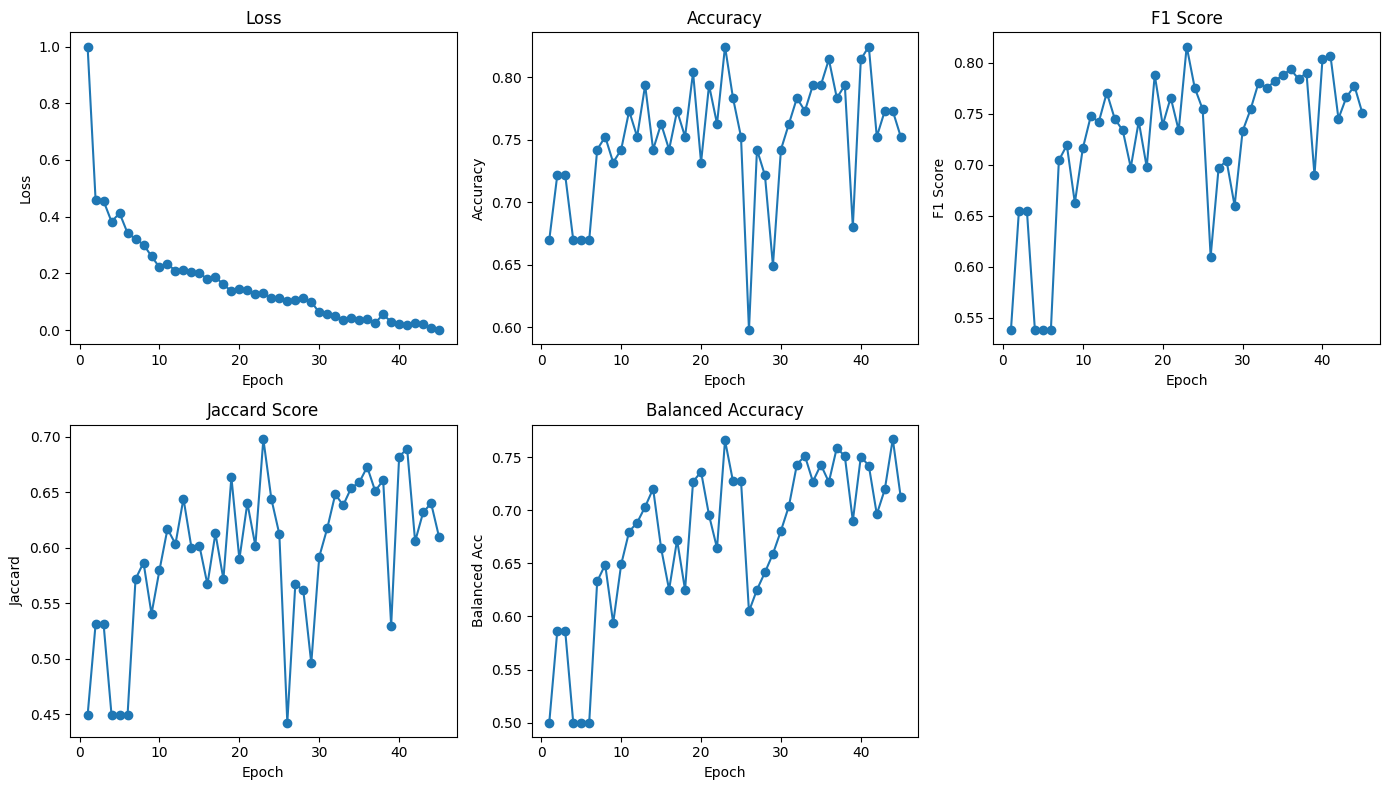

Métricas salvas em 'metricas_treino.csv'


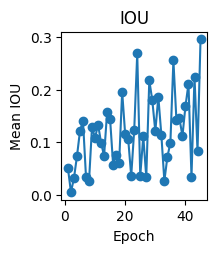

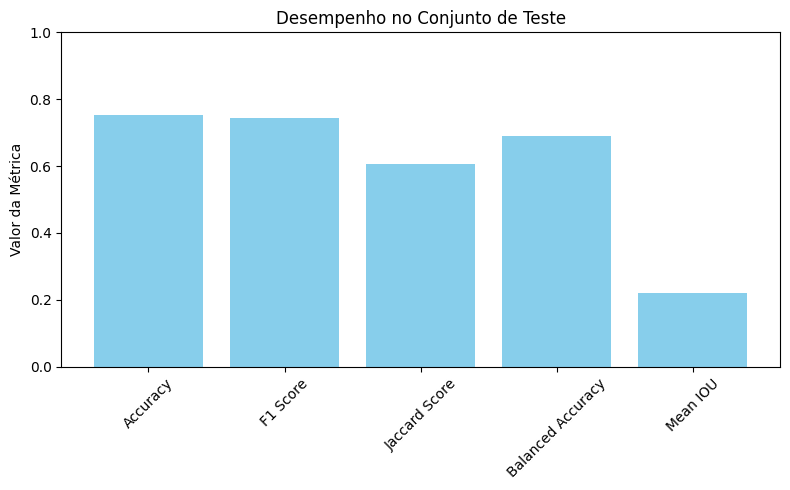

In [ ]:
import torch
import torchvision
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights
from torch.optim import SGD
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, balanced_accuracy_score
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# Configuração do modelo RetinaNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Carregar o modelo já pré treinado
model = torchvision.models.detection.retinanet_resnet50_fpn(weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT)
model.to(device)

# Otimizador
optimizer = SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Função de treino
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    model.to(device)

    all_losses = []
    val_accuracies, val_f1s, val_jaccards, val_balanced_accuracies, val_ious = [], [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        all_losses.append(epoch_loss)

        # Validação
        model.eval()
        y_true, y_pred, ious = [], [], []
        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                outputs = model(images)

                for out, target in zip(outputs, targets):
                    if len(out["labels"]) == 0:
                        continue
                    y_pred.append(out["labels"][0].cpu().item())
                    y_true.append(target["labels"][0].cpu().item())
                    ious.append(compute_iou(out["boxes"][0].cpu().numpy(), target["boxes"][0].cpu().numpy()))

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        jaccard = jaccard_score(y_true, y_pred, average='weighted', zero_division=0)
        bal_acc = balanced_accuracy_score(y_true, y_pred)
        mean_iou = sum(ious) / len(ious) if ious else 0.0

        val_accuracies.append(acc)
        val_f1s.append(f1)
        val_jaccards.append(jaccard)
        val_balanced_accuracies.append(bal_acc)
        val_ious.append(mean_iou)

        print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} | Val Acc: {acc:.4f} | F1: {f1:.4f} | Jaccard: {jaccard:.4f} | Balanced Acc: {bal_acc:.4f} | IOU: {mean_iou:.4f}")

    # Normalizar perdas
    loss_min, loss_max = min(all_losses), max(all_losses)
    normalized_losses = [(l - loss_min) / (loss_max - loss_min) if loss_max != loss_min else 0 for l in all_losses]

    torch.save(model.state_dict(), "retinanet_trained.pth")

    return normalized_losses, val_accuracies, val_f1s, val_jaccards, val_balanced_accuracies, val_ious



# Iniciar treino
normalized_losses, all_accuracies, all_f1s, all_jaccards, all_balanced_accuracies, all_ious = train_model(
    model, train_loader, val_loader, optimizer, num_epochs=45
)

def evaluate_on_test(model, test_loader):
    model.eval()
    y_true, y_pred, ious = [], [], []

    with torch.no_grad():
        for images, targets in test_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            for out, target in zip(outputs, targets):
                if len(out["labels"]) == 0:
                    continue
                y_pred.append(out["labels"][0].cpu().item())
                y_true.append(target["labels"][0].cpu().item())
                ious.append(compute_iou(out["boxes"][0].cpu().numpy(), target["boxes"][0].cpu().numpy()))

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    jaccard = jaccard_score(y_true, y_pred, average='weighted', zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    mean_iou = sum(ious) / len(ious) if ious else 0.0

    print("\n--- Avaliação Final no Teste ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Jaccard Score: {jaccard:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"Mean IOU: {mean_iou:.4f}")

    # Guardar em CSV
    df_test_metrics = pd.DataFrame([{
        'Accuracy': acc,
        'F1 Score': f1,
        'Jaccard Score': jaccard,
        'Balanced Accuracy': bal_acc,
        'Mean IOU': mean_iou
    }])
    df_test_metrics.to_csv("metricas_teste.csv", index=False)
    print("Métricas de teste salvas em 'metricas_teste.csv'")

# Executar avaliação
evaluate_on_test(model, test_loader)

# Coloca o modelo em modo de avaliação após o treino
model.eval()

# Gerar gráficos das métricas
epochs = list(range(1, len(normalized_losses) + 1))

plt.figure(figsize=(14, 8))

# Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, normalized_losses, marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs, all_accuracies, marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# F1 Score
plt.subplot(2, 3, 3)
plt.plot(epochs, all_f1s, marker='o')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

# Jaccard Score
plt.subplot(2, 3, 4)
plt.plot(epochs, all_jaccards, marker='o')
plt.title('Jaccard Score')
plt.xlabel('Epoch')
plt.ylabel('Jaccard')

# Balanced Accuracy
plt.subplot(2, 3, 5)
plt.plot(epochs, all_balanced_accuracies, marker='o')
plt.title('Balanced Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Balanced Acc')

plt.tight_layout()
plt.savefig("metricas_treino.png")
plt.show()

#IOU
plt.subplot(2, 3, 6)
plt.plot(epochs, all_ious, marker='o')
plt.title('IOU')
plt.xlabel('Epoch')
plt.ylabel('Mean IOU')

df_metrics = pd.DataFrame({
    'Epoch': epochs,
    'Loss': normalized_losses,
    'Accuracy': all_accuracies,
    'F1 Score': all_f1s,
    'Jaccard Score': all_jaccards,
    'Balanced Accuracy': all_balanced_accuracies,
    'IOU': all_ious
})
df_metrics.to_csv("metricas_treino.csv", index=False)
print("Métricas salvas em 'metricas_treino.csv'")

df_test = pd.read_csv("metricas_teste.csv")

plt.figure(figsize=(8, 5))
plt.bar(df_test.columns, df_test.iloc[0], color='skyblue')
plt.ylim(0, 1)
plt.title("Desempenho no Conjunto de Teste")
plt.ylabel("Valor da Métrica")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("grafico_métricas_teste.png")
plt.show()